# Rossmann stores - Part II: weather data

In this notebook, we introduce weather features in the data rossman data set. 
We use these features as regressors in propeht

## Importing libraries and reading Rossmann Data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import datetime
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [17]:
from prophet import Prophet

In [18]:
from datetime import datetime
from datetime import timedelta

import plotly.graph_objects as go
import plotly.express as px

from metrics import rmse, rmsep,  rmspe
from plot_methods import *


In [ ]:
# https://kb.bullseyelocations.com/article/58-germany-state-codes

In [19]:
weather_BW = pd.read_csv("./data/weather/BadenWürttemberg.csv", parse_dates=[0], sep = ';', engine = 'python')
weather_BW['State'] = 'BW'
weather_BY = pd.read_csv("./data/weather/Bayern.csv", parse_dates=[0], sep = ';')
weather_BY['State'] = 'BY'
weather_BE = pd.read_csv("./data/weather/Berlin.csv", parse_dates=[0], sep = ';')
weather_BE['State'] = 'BE'
#weather_BB = pd.read_csv("./data/weather/Brandenburg.csv", parse_dates=[1])
weather_HB = pd.read_csv("./data/weather/Bremen.csv", parse_dates=[0], sep = ';')
weather_HB['State'] = 'HB'
weather_HH = pd.read_csv("./data/weather/Hamburg.csv", parse_dates=[0], sep = ';')
weather_HH['State'] = 'HH'
weather_HE = pd.read_csv("./data/weather/Hessen.csv", parse_dates=[0], sep = ';')
weather_HE['State'] = 'HE'
#weather_MV = pd.read_csv("./data/weather/MecklenburgVorpommern.csv", parse_dates=[1])
weather_NW = pd.read_csv("./data/weather/NordrheinWestfalen.csv", parse_dates=[0], sep = ';')
weather_NW['State'] = 'NW'
weather_RP = pd.read_csv("./data/weather/RheinlandPfalz.csv", parse_dates=[0], sep = ';')
weather_RP['State'] = 'RP'
#weather_SL = pd.read_csv("./data/weather/Saarland.csv", parse_dates=[1])
weather_SN = pd.read_csv("./data/weather/Sachsen.csv", parse_dates=[0], sep = ';')
weather_SN['State'] = 'SN'
weather_ST = pd.read_csv("./data/weather/SachsenAnhalt.csv", parse_dates=[0], sep = ';')
weather_ST['State'] = 'ST'
weather_SH = pd.read_csv("./data/weather/SchleswigHolstein.csv", parse_dates=[0], sep = ';')
weather_SH['State'] = 'SH'
weather_TH = pd.read_csv("./data/weather/Thüringen.csv", parse_dates=[0], sep = ';', engine = 'python')
weather_TH['State'] = 'TH'


In [5]:

weather_combined = pd.concat([weather_BW,weather_BY,weather_BE,weather_HB,weather_HH,weather_HE,
                             weather_NW,weather_RP,weather_SN,weather_ST,weather_SH,weather_TH])
weather_combined.Events = weather_combined.Events.fillna('Normal')
weather_combined = weather_combined[['Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
                               'Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm', 'Events','State']]

In [6]:
weather_combined

Date  Max_TemperatureC  Mean_TemperatureC  Min_TemperatureC  \
0   2013-01-01                 8                  3                -2   
1   2013-01-02                 6                  3                -1   
2   2013-01-03                 6                  2                -3   
3   2013-01-04                 9                  7                 4   
4   2013-01-05                 7                  6                 5   
..         ...               ...                ...               ...   
985 2015-09-13                23                 19                15   
986 2015-09-14                19                 16                12   
987 2015-09-15                17                 13                 9   
988 2015-09-16                19                 16                12   
989 2015-09-17                20                 17                13   

     Max_Humidity  Mean_Humidity  Min_Humidity  Precipitationmm  \
0              93             80            51             0.25   
1              93             77            52             0.00   
2              93             82            63             2.03   
3             100             89            81             0.25   
4              93             83            72             0.76   
..            ...            ...           ...              ...   
985            82             69            45             0.00   
986            98             78            54             8.89   
987            88             64            37             0.00   
988            94             70            58             2.03   
989            88             73            50             0.00   

                Events State  
0             Fog-Rain    BW  
1                 Rain    BW  
2                 Rain    BW  
3                 Rain    BW  
4                 Rain    BW  
..                 ...   ...  
985               Rain    TH  
986  Rain-Thunderstorm    TH  
987             Normal    TH  
988               Rain    TH  
989               Rain    TH  

[11880 rows x 10 columns]

 ## Prepare weather data

In [7]:
weather_combined['Events'].describe()

count     11880
unique       22
top        Rain
freq       4615
Name: Events, dtype: object

In [8]:
weather_combined['Events'] = weather_combined['Events'].replace({ 'Normal':1,  'Fog':2,'Rain':3, 'Fog-Rain':4, 'Snow':5,
                                                                   'Fog-Snow':6,'Snow-Hail':7, 'Rain-Snow':8,  'Fog-Rain-Snow':9, 'Rain-Snow-Hail':10,
                                                                   'Rain-Hail':11, 'Fog-Rain-Hail':12,'Fog-Snow-Hail':13, 'Fog-Rain-Snow-Hail':14, 'Rain-Thunderstorm':15,
                                                                   'Thunderstorm':16,  'Fog-Thunderstorm':17, 'Fog-Rain-Thunderstorm':18, 'Rain-Hail-Thunderstorm':19,
                                                                   'Rain-Snow-Thunderstorm':20,
                                                                   'Fog-Rain-Hail-Thunderstorm':21,
                                                                   'Rain-Snow-Hail-Thunderstorm':22})

norm = len(weather_combined['Events'].unique())
weather_combined['Events'] = weather_combined['Events'].apply(lambda x : x/norm)

In [9]:
weather_combined.head()

Date  Max_TemperatureC  Mean_TemperatureC  Min_TemperatureC  \
0 2013-01-01                 8                  3                -2   
1 2013-01-02                 6                  3                -1   
2 2013-01-03                 6                  2                -3   
3 2013-01-04                 9                  7                 4   
4 2013-01-05                 7                  6                 5   

   Max_Humidity  Mean_Humidity  Min_Humidity  Precipitationmm    Events State  
0            93             80            51             0.25  0.181818    BW  
1            93             77            52             0.00  0.136364    BW  
2            93             82            63             2.03  0.136364    BW  
3           100             89            81             0.25  0.136364    BW  
4            93             83            72             0.76  0.136364    BW

In [10]:
weather_combined['Precipitationmm'].describe()

count    11880.000000
mean         0.852529
std          2.619129
min          0.000000
25%          0.000000
50%          0.000000
75%          0.250000
max         58.930000
Name: Precipitationmm, dtype: float64

In [ ]:
# change precipittion to 01
# If precipitation < 0.5 precipitation = 0
# else precipitation   = 1
# 'Precipitationmm'

#weather_combined['Precipitationmm'] = weather_combined['Precipitationmm'].map(lambda x : 1 if x > 0.5 else 0 )

Quartilte method, k =  1.5
Min:  -0.375
Max:  0.625
fraction of outliers in a a total of  11880  is:  0.20521885521885522
fraction of outliers in a a total of  11880  is:  0.20521885521885522


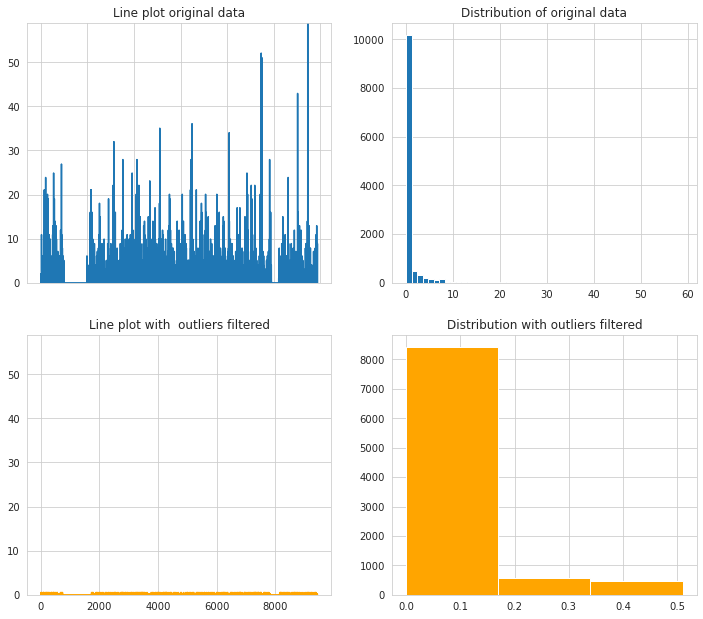

In [11]:
def plot_distr(df,name_col, method):
    X_f = choose_col(df, name_col)
    min_ = min(X_f)[0]
    max_ = max(X_f)[0]
    r, _ , _, _= method(X_f)

    plt.figure(figsize=(12,22))

    #Plot 1
    plt.subplot(4,2,1)
    #Axes.set_ylim(min_, max_)
    plt.plot(X_f)
    plt.ylim(min_, max_)
    plt.title('Line plot original data')
    # plt.xlabel('Week')
    plt.tick_params(labelbottom = False, bottom = False)

    #Plot 2
    plt.subplot(4,2,2)
    plt.hist(X_f, bins = 50)
    plt.title('Distribution of original data')
    #plt.tick_params(left = False, right = False , labelleft = False ,
    #                labelbottom = False, bottom = False)

    # LOF Detection for outliers
    plt.subplot(4,2,3)
    
    plt.plot(r, color = 'orange')
    plt.ylim(min_, max_)
    plt.title("Line plot with  outliers filtered")
    #plt.tick_params(left = False, right = False , labelleft = False ,
    #                 labelbottom = False, bottom = False)

    plt.subplot(4,2,4)
    #plt.hist(r, bins= 100, color = 'orange', range =[min_, max_])
    plt.hist(r, bins= 3, color = 'orange')
    plt.title("Distribution with outliers filtered")
    #plt.tick_params(left = False, right = False , labelleft = False ,
    #                 labelbottom = False, bottom = False)
    plt.show()


plot_distr(weather_combined, 'Precipitationmm', quartil )

## Merge data 

Merge train and test tables with store table

In [12]:
state = pd.read_csv("./data/store_states.csv")
store = pd.read_csv("./data/store.csv")

In [13]:
store = store.merge(state, on = 'Store', how = 'left')

In [14]:
train = pd.read_csv("./data/train.csv",parse_dates=[2])
test = pd.read_csv("./data/test.csv",parse_dates=[3])
# merge data with store 
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [15]:
train = train.sort_values(['Date'],ascending = False)
train_full = train.copy()

In [16]:
split_index = 6*7*1115
valid = train[:split_index] 
train = train[split_index:]

In [17]:
#valid = valid[(valid.Open != 0)&(valid.Sales >0)]
valid = valid.merge(weather_combined, on = ['Date','State'],  how = 'left', suffixes=(False,False))
#train = train[(train.Open != 0)&(train.Sales >0)]
train = train.merge(weather_combined, on = ['Date','State'],  how = 'left', suffixes = (False, False))
#train_full = train_full[(train_full.Open != 0)&(train_full.Sales >0)]

Merge stores data with weather data

In [18]:
train_full = train_full.merge(weather_combined, on = ['Date','State'],  how = 'left', suffixes=(False, False))
train_full

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1          747          5 2015-07-31  10708        826     1      1   
2          772          5 2015-07-31   5224        635     1      1   
3          752          5 2015-07-31   7763        565     1      1   
4           20          5 2015-07-31   9593        974     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1017204    260          2 2013-01-01      0          0     0      0   
1017205    995          2 2013-01-01      0          0     0      0   
1017206    261          2 2013-01-01      0          0     0      0   
1017207    262          2 2013-01-01  17267       2875     1      0   
1017208   1115          2 2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday StoreType  ...     PromoInterval  State  \
0                  0              1         c  ...               NaN     HE   
1                  0              1         c  ...               NaN     ST   
2                  0              1         d  ...               NaN     HH   
3                  0              1         a  ...   Feb,May,Aug,Nov     NW   
4                  0              0         d  ...   Jan,Apr,Jul,Oct     BY   
...              ...            ...       ...  ...               ...    ...   
1017204            a              1         a  ...               NaN     BE   
1017205            a              1         d  ...               NaN     SN   
1017206            a              1         d  ...   Jan,Apr,Jul,Oct     TH   
1017207            a              1         b  ...               NaN     HH   
1017208            a              1         d  ...  Mar,Jun,Sept,Dec     HE   

         Max_TemperatureC  Mean_TemperatureC  Min_TemperatureC  Max_Humidity  \
0                    23.0               16.0               8.0          98.0   
1                    19.0               14.0               9.0          86.0   
2                    17.0               13.0               8.0         100.0   
3                    21.0               13.0               6.0         100.0   
4                    23.0               17.0              10.0          87.0   
...                   ...                ...               ...           ...   
1017204               8.0                7.0               5.0         100.0   
1017205               7.0                5.0               3.0          81.0   
1017206               7.0                4.0               2.0          93.0   
1017207               8.0                6.0               4.0         100.0   
1017208               8.0                6.0               3.0          93.0   

         Mean_Humidity Min_Humidity Precipitationmm    Events  
0                 54.0         18.0            0.00  0.090909  
1                 55.0         27.0            0.00  0.045455  
2                 70.0         35.0            0.00  0.136364  
3                 61.0         24.0            0.00  0.090909  
4                 50.0         27.0            0.00  0.045455  
...                ...          ...             ...       ...  
1017204           78.0         62.0            0.76  0.136364  
1017205           68.0         46.0            0.00  0.136364  
1017206           74.0         55.0            0.00  0.136364  
1017207           92.0         70.0            6.10  0.136364  
1017208           80.0         59.0            2.03  0.136364  

[1017209 rows x 27 columns]

In [19]:
train_test_merged = pd.concat([train_full.sort_values('Date'), test.sort_values('Date')], axis = 0)

In [20]:
train_test_merged

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
1017208   1115          2 2013-01-01    0.0        0.0   0.0      0   
1016473    759          2 2013-01-01    0.0        0.0   0.0      0   
1016472    767          2 2013-01-01    0.0        0.0   0.0      0   
1016471    758          2 2013-01-01    0.0        0.0   0.0      0   
1016470    757          2 2013-01-01    0.0        0.0   0.0      0   
...        ...        ...        ...    ...        ...   ...    ...   
34320      926          4 2015-09-17    NaN        NaN   1.0      1   
13296      358          4 2015-09-17    NaN        NaN   1.0      1   
3360        92          4 2015-09-17    NaN        NaN   1.0      1   
21024      567          4 2015-09-17    NaN        NaN   1.0      1   
0            1          4 2015-09-17    NaN        NaN   1.0      1   

        StateHoliday  SchoolHoliday StoreType  ... State  Max_TemperatureC  \
1017208            a              1         d  ...    HE               8.0   
1016473            a              1         a  ...    NW               8.0   
1016472            a              1         a  ...    SH               8.0   
1016471            a              1         a  ...    BW               8.0   
1016470            a              1         a  ...    BW               8.0   
...              ...            ...       ...  ...   ...               ...   
34320              0              0         d  ...    NW               NaN   
13296              0              0         a  ...    NW               NaN   
3360               0              0         c  ...    NW               NaN   
21024              0              0         c  ...    NW               NaN   
0                  0              0         c  ...    HE               NaN   

         Mean_TemperatureC  Min_TemperatureC  Max_Humidity  Mean_Humidity  \
1017208                6.0               3.0          93.0           80.0   
1016473                4.0               2.0          94.0           87.0   
1016472                7.0               6.0         100.0           95.0   
1016471                3.0              -2.0          93.0           80.0   
1016470                3.0              -2.0          93.0           80.0   
...                    ...               ...           ...            ...   
34320                  NaN               NaN           NaN            NaN   
13296                  NaN               NaN           NaN            NaN   
3360                   NaN               NaN           NaN            NaN   
21024                  NaN               NaN           NaN            NaN   
0                      NaN               NaN           NaN            NaN   

         Min_Humidity Precipitationmm    Events     Id  
1017208          59.0            2.03  0.136364    NaN  
1016473          65.0            5.08  0.136364    NaN  
1016472          93.0            0.00  0.136364    NaN  
1016471          51.0            0.25  0.181818    NaN  
1016470          51.0            0.25  0.181818    NaN  
...               ...             ...       ...    ...  
34320             NaN             NaN       NaN  716.0  
13296             NaN             NaN       NaN  278.0  
3360              NaN             NaN       NaN   71.0  
21024             NaN             NaN       NaN  439.0  
0                 NaN             NaN       NaN    1.0  

[1058297 rows x 28 columns]

In [21]:
test = test.merge(weather_combined, on = ['Date','State'],  how = 'left', suffixes=(False, False))

In [22]:
train_full['Year']  = train_full['Date'].dt.year
train_full['Month'] = train_full['Date'].dt.month
train_full['WeekOfYear'] = train_full['Date'].dt.weekofyear

In [23]:
train_full['Promo2OpenInMonths'] = 12 * (train_full.Year - train_full.Promo2SinceYear) +\
                                    (train_full.WeekOfYear - train_full.Promo2SinceWeek) / 4.0
train_full['Promo2OpenInMonths'] = train_full['Promo2OpenInMonths'].apply(lambda x:x if x>0 else 0)
month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
train_full['month_str'] = train_full.Month.map(month_dict)

In [24]:
def check_promo_month(row):
    '''Indicate whether the month is in promo interval'''
    if isinstance(row['PromoInterval'],str) and (row['month_str'] in row['PromoInterval']) \
    and (row['Promo2OpenInMonths']>0):
        return 1
    else:
        return 0

In [25]:
train_full['IsPromoMonth'] =  train_full.apply(lambda row: check_promo_month(row),axis=1) 

train_full['CompetitionOpenInMonths'] = 12 * (train_full.Year - train_full.CompetitionOpenSinceYear) + \
        (train_full.Month - train_full.CompetitionOpenSinceMonth)
train_full['CompetitionOpenInMonths'] = train_full['CompetitionOpenInMonths'].apply(lambda x: x if x > 0 else 0)

# Taste of EDA

## Correlation

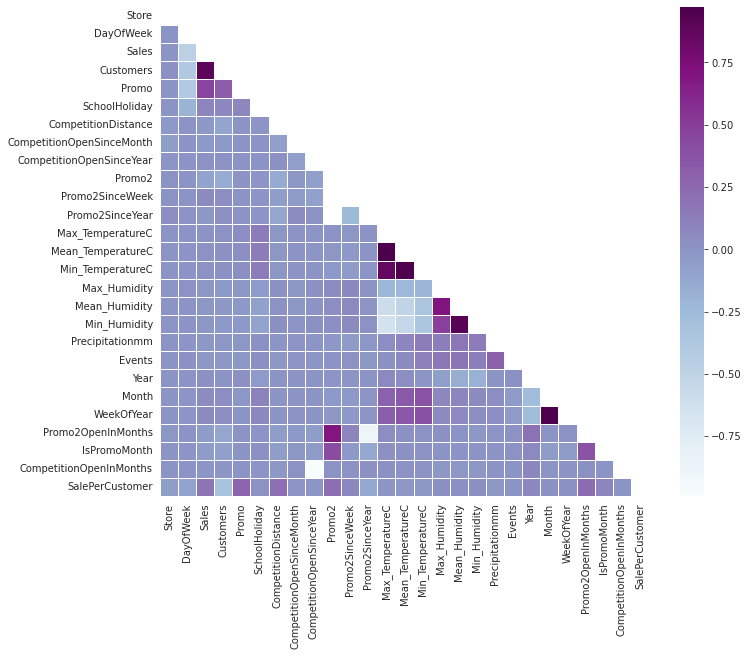

In [115]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_full.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

## Sales

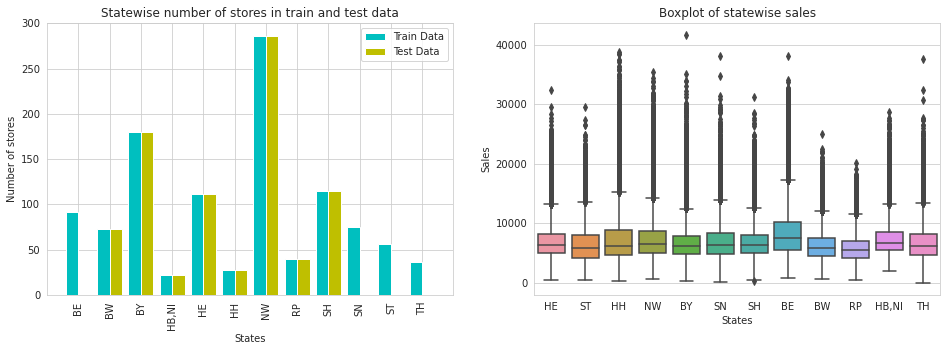

In [27]:
#States
mask = train_full['Sales']>0

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
width = 0.2
train_vals = train_full.groupby('State')['Store'].nunique()
indices = np.arange(len(train_vals))
test_vals = test.groupby('State')['Store'].nunique()
test_vals_updated = []
for ind in train_vals.index:
    if ind in test_vals.index:
        test_vals_updated.append(test_vals[ind])
    else:
        test_vals_updated.append(0)
ax1.bar(indices-width, train_vals.values , label = 'Train Data', width = 2*width, color = 'c', align = 'center')
ax1.bar(indices+width, test_vals_updated, label = 'Test Data', width = 2*width, color = 'y')
ax1.set_title('Statewise number of stores in train and test data')
ax1.set_xticks(indices)
ax1.set_xticklabels(train_vals.index, rotation='vertical')
ax1.set_ylabel('Number of stores')
ax1.set_xlabel('States')
ax1.legend()

sns.boxplot(data = train_full[mask], x='State', y='Sales', ax=ax2)
ax2.set_title('Boxplot of statewise sales')
ax2.set_xlabel('States')
plt.show()

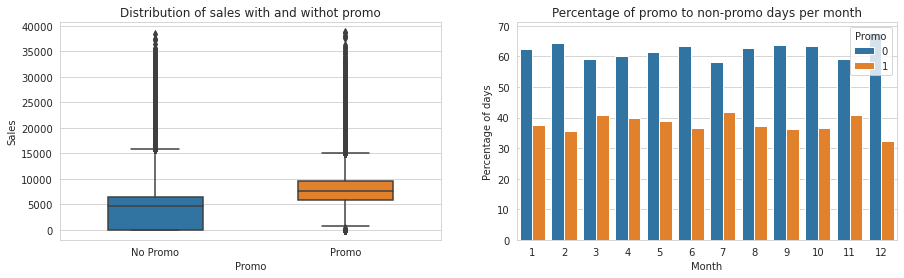

In [28]:
#https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group
# Plot average sales & customers with/without promo
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.boxplot(x='Promo', y='Sales', data=train, ax=axis1, width=0.5)
axis1.set_xticks([0,1])
axis1.set_xticklabels(['No Promo', 'Promo'])
axis1.set_title('Distribution of sales with and withot promo')

promo_month = (train_full.groupby(['Month'])['Promo']
                     .value_counts(normalize=True)
                     .rename('Percentage of days')
                     .mul(100)
                     .reset_index()
                     .sort_values('Month'))
sns.barplot(x="Month", y="Percentage of days", hue="Promo", data=promo_month, ax = axis2)
axis2.set_title('Percentage of promo to non-promo days per month')
plt.show()

## Competition Distance

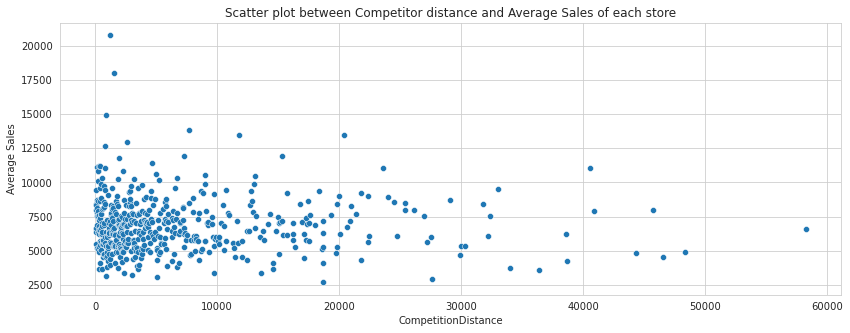

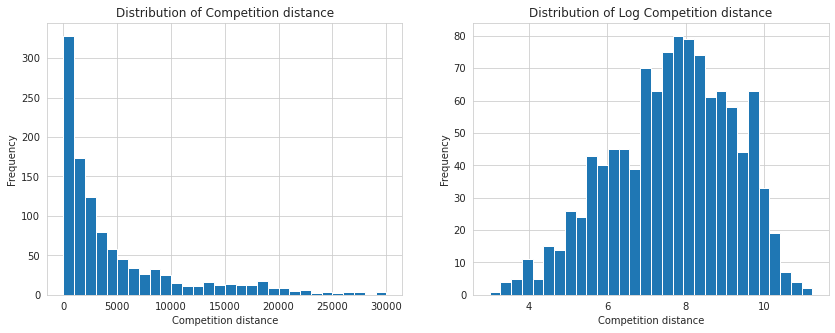

In [29]:
# CompetitionDistance
fig, axis1 = plt.subplots(1,1,figsize=(14,5))
fig, (axis2,axis3) = plt.subplots(1,2,figsize=(14,5))

# Plot CompetitionDistance Vs Sales
comp_df = train_full[(train_full['Sales']>0)&(~train_full['CompetitionDistance'].isna())&\
                    (train_full.CompetitionOpenInMonths>0)].groupby('CompetitionDistance')['Sales'].mean()
sns.scatterplot(x=comp_df.index,y=comp_df.values, ax = axis1)
axis1.set_ylabel('Average Sales')
axis1.set_title('Scatter plot between Competitor distance and Average Sales of each store')
axis2.hist(x = store['CompetitionDistance'].dropna(), bins = 30, range=(0,30000))
axis2.set_ylabel('Frequency')
axis2.set_xlabel('Competition distance')
axis2.set_title('Distribution of Competition distance')
axis3.hist(x = np.log(store['CompetitionDistance'].dropna()), bins = 30)
axis3.set_ylabel('Frequency')
axis3.set_xlabel('Competition distance')
axis3.set_title('Distribution of Log Competition distance')
plt.show()

# Prediction with prophet

In [31]:
train_full['SalePerCustomer'] = train_full['Sales']/train_full['Customers']

In [159]:
train_full.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  CompetitionDistance  \
count  1.017209e+06   1.017209e+06         1.014567e+06   
mean   3.815145e-01   1.786467e-01         5.430086e+03   
std    4.857586e-01   3.830564e-01         7.715324e+03   
min    0.000000e+00   0.000000e+00         2.000000e+01   
25%    0.000000e+00   0.000000e+00         7.100000e+02   
50%    0.000000e+00   0.000000e+00         2.330000e+03   
75%    1.000000e+00   0.000000e+00         6.890000e+03   
max    1.000000e+00   1.000000e+00         7.586000e+04   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear  ...  \
count              693861.000000             693861.000000  ...   
mean                    7.222866               2008.690228  ...   
std                     3.211832                  5.992644  ...   
min                     1.000000               1900.000000  ...   
25%                     4.000000               2006.000000  ...   
50%                     8.000000               2010.000000  ...   
75%                    10.000000               2013.000000  ...   
max                    12.000000               2015.000000  ...   

        Min_Humidity  Precipitationmm         Events          Year  \
count  996485.000000     1.017209e+06  996485.000000  1.017209e+06   
mean       49.904524     2.228608e-01       0.169626  2.013832e+03   
std        19.648367     4.161659e-01       0.167257  7.773960e-01   
min         8.000000     0.000000e+00       0.045455  2.013000e+03   
25%        34.000000     0.000000e+00       0.090909  2.013000e+03   
50%        49.000000     0.000000e+00       0.136364  2.014000e+03   
75%        65.000000     0.000000e+00       0.181818  2.014000e+03   
max       100.000000     1.000000e+00       1.000000  2.015000e+03   

              Month    WeekOfYear  Promo2OpenInMonths  IsPromoMonth  \
count  1.017209e+06  1.017209e+06        1.017209e+06  1.017209e+06   
mean   5.846762e+00  2.361551e+01        1.311154e+01  1.487099e-01   
std    3.326097e+00  1.443338e+01        1.900784e+01  3.558024e-01   
min    1.000000e+00  1.000000e+00        0.000000e+00  0.000000e+00   
25%    3.000000e+00  1.100000e+01        0.000000e+00  0.000000e+00   
50%    6.000000e+00  2.200000e+01        0.000000e+00  0.000000e+00   
75%    8.000000e+00  3.500000e+01        2.500000e+01  0.000000e+00   
max    1.200000e+01  5.200000e+01        7.200000e+01  1.000000e+00   

       CompetitionOpenInMonths  SalePerCustomer  
count             1.017209e+06    844340.000000  
mean              4.203993e+01         9.493619  
std               6.534447e+01         2.197494  
min               0.000000e+00         0.000000  
25%               0.000000e+00         7.895563  
50%               1.600000e+01         9.250000  
75%               7.300000e+01        10.899729  
max               1.386000e+03        64.957854  

[8 rows x 28 columns]

## Regular predicitons

In [37]:
df_122 =  train_full[train_full['Store'] == 122]
print("# cero sales: ",  len(df_122[df_122['Sales']==0]) )
df_122 = df_122.loc[:,['Date', 'Sales', 'Mean_TemperatureC']] # Store type A
df_122 = df_122.sort_index(ascending = False)
df_122['Date'] = pd.DatetimeIndex(df_122['Date'])
sales = df_122.rename(columns = {'Date': 'ds', 'Sales': 'y', 'Mean_TemperatureC': 'Mean_TemperatureC'})
sales = sales.fillna(0)
sales

ds      y  Mean_TemperatureC
1016664 2013-01-01      0                7.0
1015183 2013-01-02   6719                6.0
1014560 2013-01-03   4634                8.0
1013481 2013-01-04   5248                7.0
1012401 2013-01-05   5141                7.0
...            ...    ...                ...
4929    2015-07-27  14461               16.0
4388    2015-07-28  12205               16.0
2446    2015-07-29  11446               14.0
1486    2015-07-30  10576               14.0
1014    2015-07-31  12336               14.0

[942 rows x 3 columns]

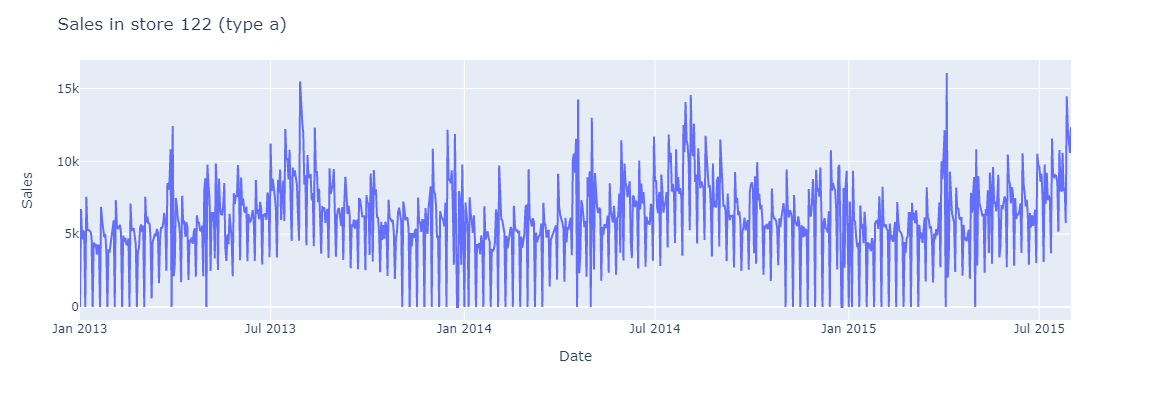

In [38]:
fig = px.line(x=sales['ds'], y=sales['y'])
fig.update_layout(xaxis_title = "Date",
                  yaxis_title = 'Sales',
                  title = " Sales in store 122 (type a)",
                  height = 400)
fig.show()

In [160]:
# Rename 
df = train_full

In [43]:
# create holidays dataframe

state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays

holiday         ds
0        state_holiday 2015-06-04
1        state_holiday 2015-06-04
2        state_holiday 2015-06-04
3        state_holiday 2015-06-04
4        state_holiday 2015-06-04
...                ...        ...
181716  school_holiday 2013-01-01
181717  school_holiday 2013-01-01
181718  school_holiday 2013-01-01
181719  school_holiday 2013-01-01
181720  school_holiday 2013-01-01

[201981 rows x 2 columns]

In [44]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                         holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

#print("First week to forecast.")
#future_dates.tail(7)

forecast = my_model.predict(future_dates)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -34.2328
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1763.6     0.0514242        156.06      0.4292           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100        1763.7    0.00131068       230.964   8.399e-06       0.001      140  LS failed, Hessian reset 
     153       1767.02    0.00394746       313.057   2.597e-05       0.001      228  LS failed, Hessian reset 
     199       1768.58   1.69148e-05        86.095      0.4097      0.4097      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       1769.17    0.00601088       225.845   3.805e-05       0.001      410  LS failed, Hessian reset 
     299       1769.54   4.06182e-05       95.2508           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

In [47]:
def time_interval(some_df):
    one_year = timedelta(days=365)
    last = len(some_df)

    last = some_df.ds.values[last-1]
    last = pd.to_datetime(last)

    start = last - one_year 
    
    return start, last

In [48]:
def plot_individual_store_prediction(df_forecast, df_sales, store, feature):
    
    start, end = time_interval(df_forecast)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x = df_sales['ds'],   y = df_sales['y']     , name = "actual" ))
    fig.add_trace(go.Scatter(x = df_forecast.ds,   y = df_forecast.yhat  , name = "forecast" ))
    fig.add_trace(go.Scatter(x = df_forecast.ds,   y = df_forecast.yhat_upper , mode = 'lines', line = dict(width = 0), hoverinfo = "skip", showlegend = False, name = "Upper" ))
    fig.add_trace(go.Scatter(x = df_forecast.ds,   y = df_forecast.yhat_lower , mode = 'lines', line = dict(width = 0) , fillcolor= 'rgba(68,68,68, 0.2)', fill = "tonexty", hoverinfo = "skip", showlegend = False, name = "Upper" ))

    fig.update_layout(xaxis_title = "Date",
                      yaxis_title = feature,
                      title = "Forecast: open on sundays - Store no. " + str(store),
                      height = 400,
                      xaxis_range = [start, end]   )

    print("Showing only one year of data")

    return fig

Showing only one year of data


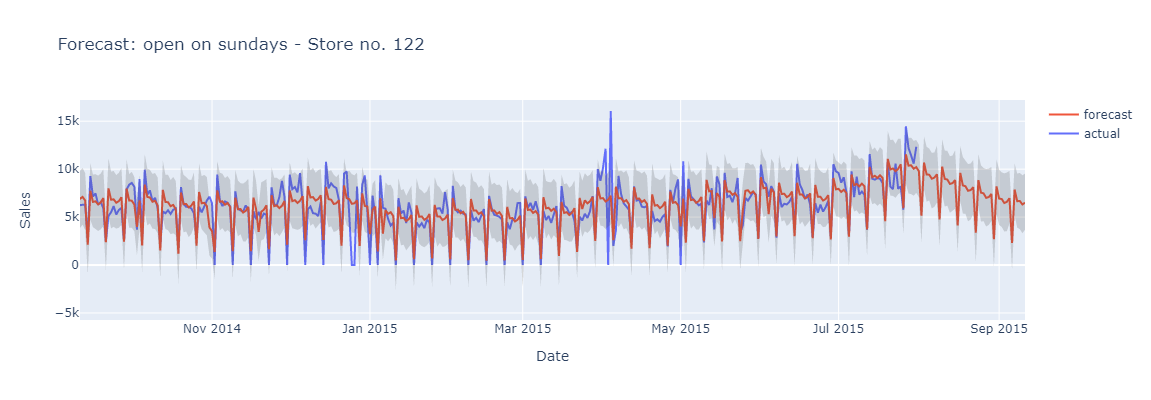

In [49]:
plot_individual_store_prediction(forecast, sales, 122, 'Sales')

In [56]:
forecast['yhat']

0      3017.279319
1      5410.425506
2      4988.043084
3      5112.288597
4      5492.191804
          ...     
979    7870.480845
980    6657.511885
981    6677.285267
982    6318.490756
983    6503.721135
Name: yhat, Length: 984, dtype: float64

In [53]:
rmse( sales['y'], forecast['yhat']), rmsep(sales['y'], forecast['yhat'])

(nan, nan)

## Prediction with regessor

In [196]:
my_model_w = Prophet(interval_width = 0.95, 
                         holidays = holidays)
my_model_w.add_regressor('Mean_TemperatureC')

my_model_w.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model_w.make_future_dataframe(periods = 6*7)

#print("First week to forecast.")
#future_dates.tail(7)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -34.2328
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1763.01    0.00318611       105.872           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       1767.96    0.00187781       183.569   1.234e-05       0.001      201  LS failed, Hessian reset 
     199       1769.02   0.000614696       99.6608      0.6597      0.6597      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       1769.51   0.000855333       170.544   5.362e-06       0.001      310  LS failed, Hessian reset 
     299       1769.96    0.00017554       96.6322           1           1      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     358       1769.97   4.93433e-07         89.74   5.653e-09       0.001      530  LS failed, Hessian rese

In [197]:
future_dates['Mean_TemperatureC'] = df_122['Mean_TemperatureC']
future_dates['Mean_TemperatureC'] = future_dates['Mean_TemperatureC'].fillna(0)


In [198]:
forecast = my_model_w.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)


Showing only one year of data


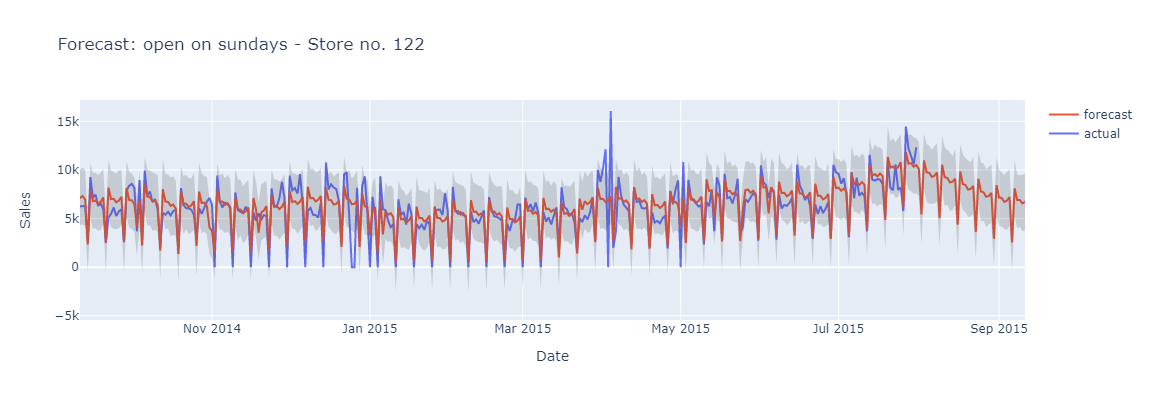

In [199]:
plot_individual_store_prediction(forecast, sales, 122, 'Sales')

In [240]:
rmse( sales['y'], forecast['yhat']), rmsep(sales['y'], forecast['yhat'])

(6668.042129991216, 1.0983431006460047)

In [116]:
def make_individual_prediction(df, feature, n_store, holidays):
    """ df: dataframe
        n_store: integer that represents a store
        holidays: df with the holydays
        
        returns:
        forecast: df with the forecast produced by prophet
        sales: ts with sales per customer (modified)
        n_store: store number that has been processed
        
    """
    
    this_df = df[df['Store'] == n_store].loc[:,['Date', feature]]
    this_df = this_df.sort_index(ascending = False)
    this_df['Date'] = pd.DatetimeIndex(this_df['Date'])
    sales = this_df.rename(columns = {'Date': 'ds', feature : 'y'})
    sales = sales.fillna(0)
    
    my_model = Prophet(interval_width = 0.95, 
                         holidays = holidays)
    my_model.fit(sales)

    # dataframe that extends into future 6 weeks 
    future_dates = my_model.make_future_dataframe(periods = 6*7)

    #print("First week to forecast.")
    #future_dates.tail(7)
    
    forecast = my_model.predict(future_dates)

    # preditions for last week
    #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
    
    print("Finished calculating Forecast for store: " + str(n_store))
    return forecast, sales, n_store, feature


In [123]:
a,b,c,d = make_individual_prediction(train_full, 'Customers', 122, holidays)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -39.2015
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       1828.14    0.00141273       222.854   1.139e-05       0.001      153  LS failed, Hessian reset 
      99       1828.29    0.00111999       131.174           1           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       1832.89    0.00307247       205.489   2.615e-05       0.001      246  LS failed, Hessian reset 
     199       1834.97    3.7142e-05       75.3508      0.6604      0.6604      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       1835.35   0.000821545       181.819   6.417e-06       0.001      376  LS failed, Hessian reset 
     299       1835.54   0.000136877       73.6851           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Showing only one year of data


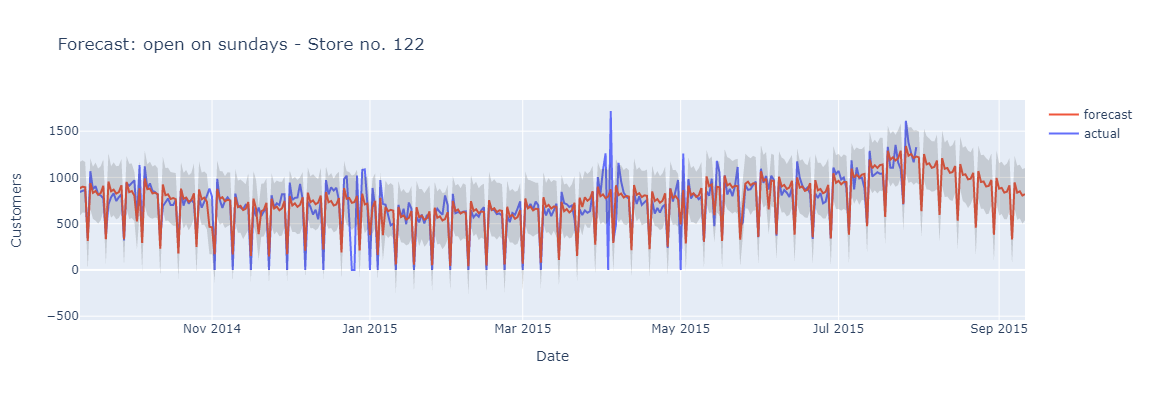

In [124]:
plot_individual_store_prediction(a, b, c, d)

In [125]:
#len(a), len(b)
a = a.drop(a.index[a.index >= len(b)])

print(rmse(  b['y'].array, a['yhat'].array))
print(rmsep( b['y'].array, a['yhat'].array))
print(rmspe( b['y'].array, a['yhat'].array))

148.4245577192218
0.19902737292668848
inf


In [90]:
def make_individual_prediction_regressor(df, feature, n_store, holidays, w_feature):
    """ df: dataframe
        n_store: integer that represents a store
        holidays: df with the holydays
        w_feature: one in list
        
        returns:
        forecast: df with the forecast produced by prophet
        sales: ts with sales per customer (modified)
        n_store: store number that has been processed
        w_feature: weather feature
        
    """
    
    this_df = df[df['Store'] == n_store].loc[:,['Date', feature, w_feature]]
    this_df = this_df.sort_index(ascending = False)
    this_df['Date'] = pd.DatetimeIndex(this_df['Date'])
    sales = this_df.rename(columns = {'Date': 'ds', feature : 'y', w_feature: w_feature})
    #sales = df_122.rename(columns = {'Date': 'ds', 'Sales': 'y', 'Mean_TemperatureC': 'Mean_TemperatureC'})
    sales = sales.fillna(0)
    
    my_model = Prophet(interval_width = 0.95,  holidays = holidays)
    my_model.add_regressor(w_feature)
    my_model.fit(sales)

    # dataframe that extends into future 6 weeks 
    future_dates = my_model.make_future_dataframe(periods = 6*7)

    future_dates[w_feature] = df[w_feature]
    future_dates[w_feature] = future_dates[w_feature].fillna(0)
    
    forecast = my_model.predict(future_dates)

    
    print("Finished calculating Forecast for store: " + str(n_store))
    print("feature: " + str(feature))
    print("weather: " + str(w_feature))
    return forecast, sales, n_store, feature, w_feature

In [167]:
a_temp, b_temp, c_temp, d_temp, e_temp =  make_individual_prediction_regressor(train_full, "Customers", 122, holidays, "Precipitationmm")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -39.2015
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          1830     0.0320388       196.734           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       1833.17    0.00454107       291.975   5.186e-05       0.001      200  LS failed, Hessian reset 
     199        1835.4   0.000315218       75.3984      0.4454     0.04454      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1835.87   7.51683e-06       92.5439   9.472e-08       0.001      432  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.89   5.61226e-06       67.5257      0.7853      0.2272      567   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     413       1

In [168]:
# metric

#len(b['y']),len(a['yhat'])

a_temp = a_temp.drop(a_temp.index[a_temp.index >= len(b_temp)])


In [169]:
rmse( b_temp['y'].array, a_temp['yhat'].array), rmsep( b_temp['y'].array, a_temp['yhat'].array), rmspe( b_temp['y'].array, a_temp['yhat'].array)


(148.45569253100203, 0.19906912262020554, inf)

Showing only one year of data


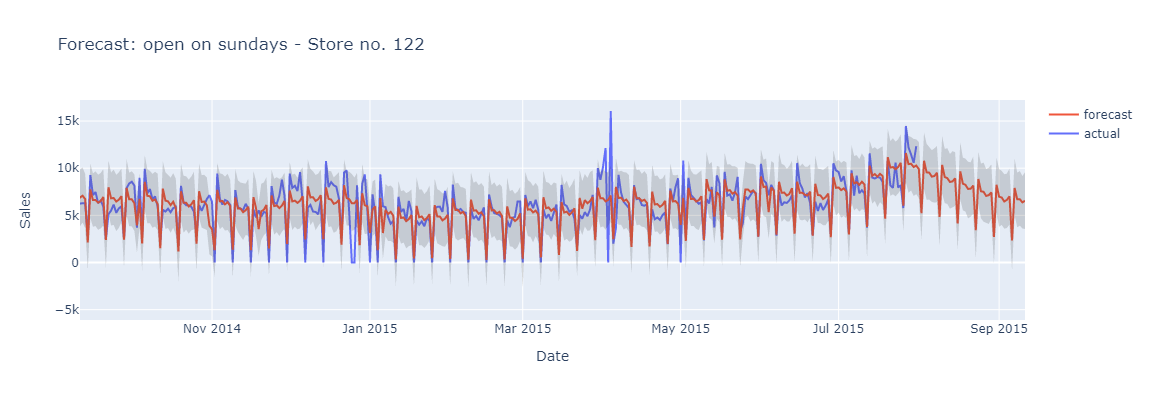

In [247]:
plot_individual_store_prediction(a_temp, b_temp, c_temp, d_temp)

In [ ]:
df[(df['DayOfWeek']==7)&(df['Open']==1)&(df['StoreType']==a)].Store.unique()


In [126]:
# WARNING!!!! tHIS BLOCK TAKES TIME 
# This block performs all predictions for one store 
#[['Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC','Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm', 'Events','State']]

weather_features = ['Mean_TemperatureC','Mean_Humidity', 'Precipitationmm', 'Events']
store = 122
dic_predictions = {}
feature = "Customers"


for store in stores :
    for item in weather_features:
        forecast_, sales_,  _ , _,  w_feat= make_individual_prediction_regressor(df, feature ,  store, holidays, item)
        dic_ = {'store': store, 'forecast': forecast_ ,'sales': sales_ , 'weather_feature': w_feat  }
        dic_predictions[str(item)] = dic_
    
    
    
#print(dic_predictions)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -39.2015
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1828.52    0.00925088       187.258      0.2097           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       1830.76   0.000944168       192.987   7.679e-06       0.001      165  LS failed, Hessian reset 
     162       1833.26   0.000721866       157.672   3.148e-06       0.001      250  LS failed, Hessian reset 
     199       1834.57     0.0039936       125.331      0.3563           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       1835.55    0.00138722       245.145    1.14e-05       0.001      357  LS failed, Hessian reset 
     299       1835.84   2.65319e-07       60.2816      0.9359      0.9359      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Finished calculating Forecast for store: 122
feature: Customers
weather: Mean_TemperatureC
Initial log joint probability = -39.2015
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1829.74      0.009549       177.604           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       1836.76    0.00159981       117.516   1.432e-05       0.001      252  LS failed, Hessian reset 
     199        1836.9   0.000145261       80.3505      0.3779           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       1836.91   1.18085e-07       78.7758           1           1      328   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Finished calculating Forecast for store: 122
feature: Customers
weather: Mean_Humidity


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -39.2015
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1826.98     0.0145611       310.281           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       1834.94   0.000722156       167.977   4.631e-06       0.001      242  LS failed, Hessian reset 
     199       1835.47    0.00230037       119.493           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       1835.63   4.71621e-08       69.0191      0.3298           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Finished calculating Forecast for store: 122
feature: Customers
weather: Precipitationmm


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -39.2015
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1832.33     0.0167525       203.594      0.5306           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       1833.87   0.000789095       148.858   5.594e-06       0.001      169  LS failed, Hessian reset 
     199        1838.1    0.00044518       74.6999      0.3367           1      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223        1838.8   0.000617827        152.65   3.578e-06       0.001      349  LS failed, Hessian reset 
     260       1839.15   0.000161018       67.7863     1.8e-06       0.001      437  LS failed, Hessian reset 
     299       1839.16   5.97487e-07       59.2971      0.5476      0.5476      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

In [106]:
y_ = dic_predictions['Events']['forecast']

In [107]:
actual = dic_predictions['Events']['sales']

In [109]:
y_ =  y_.drop(y_.index[y_.index >= len(actual)])

In [110]:
rmse( actual['y'].array, y_['yhat'].array), rmsep( actual['y'].array, y_['yhat'].array), rmspe( actual['y'].array, y_['yhat'].array)

(1488.9872879712264, 0.24526223482258602, inf)

In [127]:
#a_temp = a_temp.drop(a_temp.index[a_temp.index >= len(b_temp)])

for w in weather_features:
    y_ = dic_predictions[w]['forecast']
    actual = dic_predictions[w]['sales']
    y_ =  y_.drop(y_.index[y_.index >= len(actual)])
    res = rmse( actual['y'].array, y_['yhat'].array)
    res2 = rmsep( actual['y'].array, y_['yhat'].array)
    print(str(w),  "rmse: ", res, res2)


Mean_TemperatureC rmse:  148.59678761119915 0.1992583216555676
Mean_Humidity rmse:  149.5293644923113 0.20050884467919708
Precipitationmm rmse:  148.43196894950233 0.19903731088921675
Events rmse:  148.5391060412105 0.19918097454052447


<!-- Results for feature "Sales", store 122

#no regressor             1488.8822805084085 0.24524493825785923
#Mean_TemperatureC rmse:  1491.628167489056  0.24569723384351294
#Mean_Humidity rmse:      1491.3424363320294 0.2456501689271789
#Precipitationmm rmse:    1489.1383999965162 0.24528712561469054
#Events rmse:             1488.9872879712264 0.24526223482258602

# precipitation(0,1)      1489.010863231162, 0.24526611808000873

In [ ]:
#Results for feature 'SaleperCustomer' store 122

# no regressor                1.693172263947844    0.22291646876633958
# Mean_TemperatureC rmse:     1.695262341253814    0.22319164020779064
# Mean_Humidity rmse:         1.6970701901617413   0.22342965455706815
# Precipitationmm rmse:       1.6951496210673591   0.2231767999068607
# Events rmse:                1.693271381807418    0.22292951823786614

#precipitation (0,1)          1.6953058370281926, 0.22319736669211668

In [ ]:
# Results for feature "customers"

#no regressor no regressor  148.4245577192218    0.19902737292668848
# Mean_TemperatureC rmse:   148.59678761119915   0.1992583216555676
# Mean_Humidity rmse:       149.5293644923113    0.20050884467919708
# Precipitationmm rmse:     148.43196894950233   0.19903731088921675
# Events rmse:              148.5391060412105    0.19918097454052447

# Precipiationmm (0,1)      148.45569253100203, 0.19906912262020554